# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Предобработка данных

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats as st
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
import warnings
from sklearn.metrics import make_scorer
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder
import lightgbm as lgb
import catboost
from category_encoders import TargetEncoder

In [2]:
df = pd.read_csv('C:/datasc/pracfiles/autos.csv')
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [3]:
print(len(df[df.duplicated()]))
df = df.drop_duplicates()

4


In [4]:
len(df[df.duplicated()])

0

In [5]:
df = df.drop(['DateCrawled', 'RegistrationMonth', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen', 'Brand'], axis=1)
df.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,no


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354365 entries, 0 to 354368
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             354365 non-null  int64 
 1   VehicleType       316875 non-null  object
 2   RegistrationYear  354365 non-null  int64 
 3   Gearbox           334532 non-null  object
 4   Power             354365 non-null  int64 
 5   Model             334660 non-null  object
 6   Kilometer         354365 non-null  int64 
 7   FuelType          321470 non-null  object
 8   Repaired          283211 non-null  object
dtypes: int64(4), object(5)
memory usage: 27.0+ MB


In [7]:
df['Gearbox'].unique()

array(['manual', 'auto', nan], dtype=object)

In [8]:
df['VehicleType'].unique()

array([nan, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

In [9]:
df['Model'].unique()


array(['golf', nan, 'grand', 'fabia', '3er', '2_reihe', 'other', 'c_max',
       '3_reihe', 'passat', 'navara', 'ka', 'polo', 'twingo', 'a_klasse',
       'scirocco', '5er', 'meriva', 'arosa', 'c4', 'civic', 'transporter',
       'punto', 'e_klasse', 'clio', 'kadett', 'kangoo', 'corsa', 'one',
       'fortwo', '1er', 'b_klasse', 'signum', 'astra', 'a8', 'jetta',
       'fiesta', 'c_klasse', 'micra', 'vito', 'sprinter', '156', 'escort',
       'forester', 'xc_reihe', 'scenic', 'a4', 'a1', 'insignia', 'combo',
       'focus', 'tt', 'a6', 'jazz', 'omega', 'slk', '7er', '80', '147',
       '100', 'z_reihe', 'sportage', 'sorento', 'v40', 'ibiza', 'mustang',
       'eos', 'touran', 'getz', 'a3', 'almera', 'megane', 'lupo', 'r19',
       'zafira', 'caddy', 'mondeo', 'cordoba', 'colt', 'impreza',
       'vectra', 'berlingo', 'tiguan', 'i_reihe', 'espace', 'sharan',
       '6_reihe', 'panda', 'up', 'seicento', 'ceed', '5_reihe', 'yeti',
       'octavia', 'mii', 'rx_reihe', '6er', 'modus', 'fox'

In [10]:
df['FuelType'].unique()


array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

In [11]:
df.isna().sum()

Price                   0
VehicleType         37490
RegistrationYear        0
Gearbox             19833
Power                   0
Model               19705
Kilometer               0
FuelType            32895
Repaired            71154
dtype: int64

In [12]:
df['Model'].isna().sum()

19705

In [13]:
df['Repaired'].unique()

array([nan, 'yes', 'no'], dtype=object)

In [14]:
df['FuelType'] = df['FuelType'].replace(['petrol', 'gasoline', \
       float('NaN')], ['petrol/gasoline', 'petrol/gasoline', 'unknown'])
df['FuelType'].head()

0    petrol/gasoline
1    petrol/gasoline
2    petrol/gasoline
3    petrol/gasoline
4    petrol/gasoline
Name: FuelType, dtype: object

In [15]:
df.isna().sum()

Price                   0
VehicleType         37490
RegistrationYear        0
Gearbox             19833
Power                   0
Model               19705
Kilometer               0
FuelType                0
Repaired            71154
dtype: int64

In [16]:
model_info = df.groupby('Model').agg({
    'VehicleType': 'first',
}).reset_index()

df = df.merge(model_info, on='Model', suffixes=('', '_model'))

df['VehicleType'] = df['VehicleType'].fillna(df['VehicleType_model'])

df = df.drop(columns=['VehicleType_model'])
df.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Repaired
0,480,small,1993,manual,0,golf,150000,petrol/gasoline,NaN
1,1500,small,2001,manual,75,golf,150000,petrol/gasoline,no
2,999,small,1998,manual,101,golf,150000,unknown,NaN
3,245,sedan,1994,NaN,0,golf,150000,petrol/gasoline,no
4,350,small,2016,manual,75,golf,150000,petrol/gasoline,no


In [17]:
df.isna().sum()

Price                   0
VehicleType             0
RegistrationYear        0
Gearbox             15702
Power                   0
Model                   0
Kilometer               0
FuelType                0
Repaired            62100
dtype: int64

## Предварительный анализ

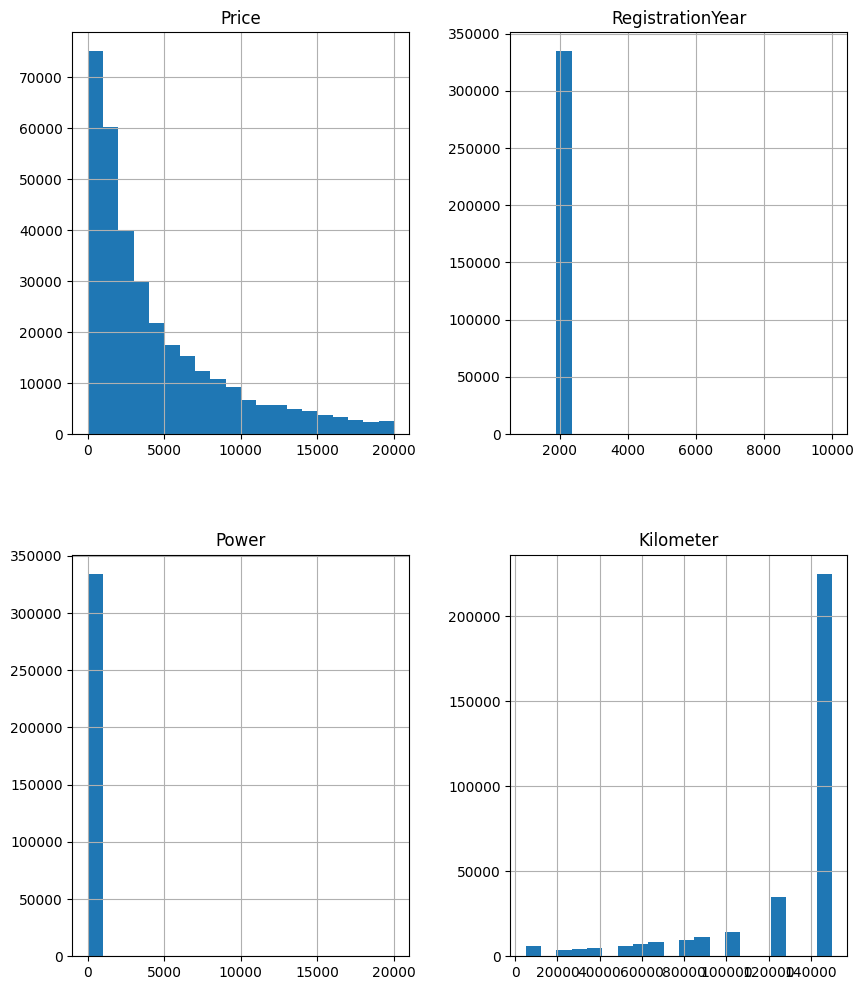

In [18]:
df.hist(figsize=(10, 12), bins=20)
plt.show()

In [19]:
df = df[(df['RegistrationYear'] <= 2016) & (df['RegistrationYear'] > 1850)]

In [20]:
df = df[(df['Power']  <= 1500)]

In [21]:
df = df[df['Price'] > 50]

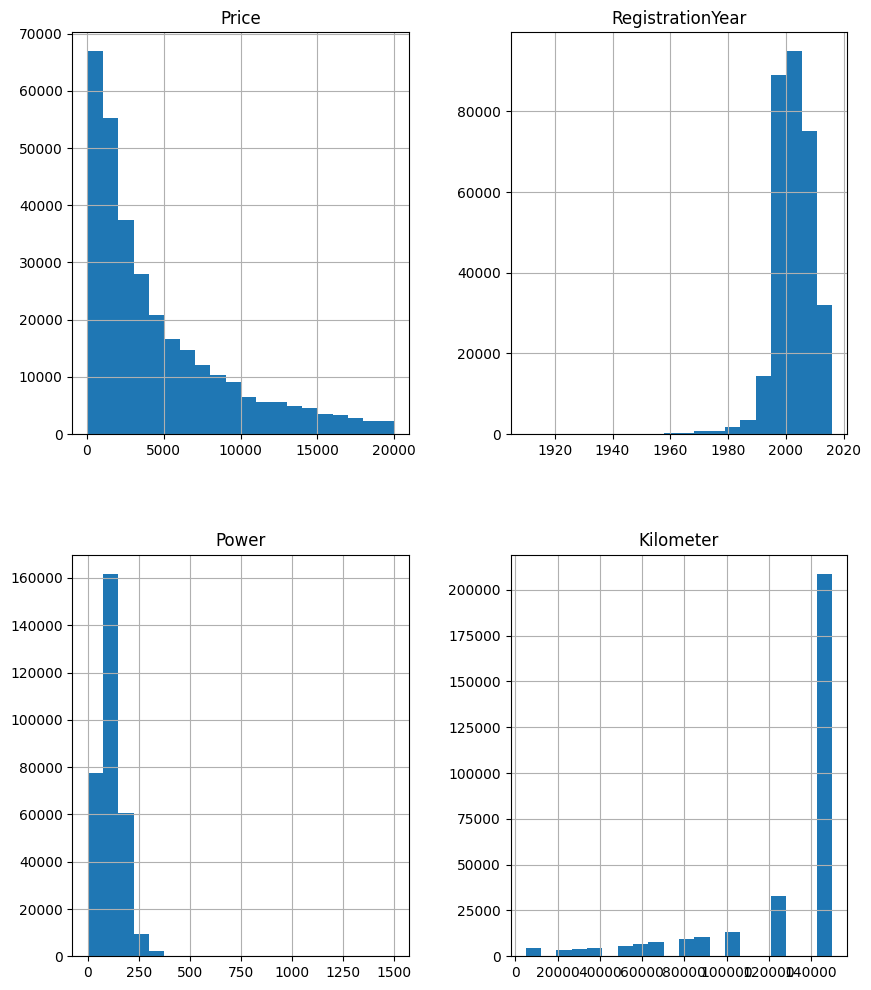

In [22]:
df.hist(figsize=(10, 12), bins=20)
plt.show()

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 312472 entries, 0 to 334658
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             312472 non-null  int64 
 1   VehicleType       312472 non-null  object
 2   RegistrationYear  312472 non-null  int64 
 3   Gearbox           300105 non-null  object
 4   Power             312472 non-null  int64 
 5   Model             312472 non-null  object
 6   Kilometer         312472 non-null  int64 
 7   FuelType          312472 non-null  object
 8   Repaired          260158 non-null  object
dtypes: int64(4), object(5)
memory usage: 23.8+ MB


## Подготовка для моделей

In [24]:
df = df.dropna()
df.isna().sum()

Price               0
VehicleType         0
RegistrationYear    0
Gearbox             0
Power               0
Model               0
Kilometer           0
FuelType            0
Repaired            0
dtype: int64

In [25]:
features = df.drop(['Price'], axis=1)
target = df['Price']

In [26]:
features_train_val, features_test, target_train_val, target_test = train_test_split(
    features, target, test_size=0.2, random_state=12345)
print(features_train_val.shape)
print(target_test.shape)
features_train, features_valid, target_train, target_valid = train_test_split(
    features_train_val, target_train_val, test_size=0.25, random_state=12345)
print(features_train.shape)
print(target_valid.shape)

(203663, 8)
(50916,)
(152747, 8)
(50916,)


In [27]:
numeric = ['VehicleType', 'Model', 'Repaired', 'Gearbox', 'FuelType']

In [28]:
target_encoder = TargetEncoder()
target_encoder.fit(features_train[numeric], target_train)
features_train[numeric] = target_encoder.transform(features_train[numeric])
features_valid[numeric] = target_encoder.transform(features_valid[numeric])
features_test[numeric] = target_encoder.transform(features_test[numeric])

c:\intrptr\envs\practicum\lib\site-packages\pandas\core\frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [29]:
scaler = StandardScaler()
scaler.fit(features_train)
features_train = scaler.transform(features_train)
features_valid = scaler.transform(features_valid)
features_test = scaler.transform(features_test)
features.head()

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Repaired
1,small,2001,manual,75,golf,150000,petrol/gasoline,no
4,small,2016,manual,75,golf,150000,petrol/gasoline,no
6,sedan,1998,manual,101,golf,150000,petrol/gasoline,no
7,sedan,2006,manual,105,golf,150000,petrol/gasoline,no
10,sedan,2002,manual,265,golf,150000,petrol/gasoline,no


## Модели

In [30]:
%%time
linear_model = LinearRegression()
linear_model.fit(features_train, target_train)

CPU times: total: 62.5 ms
Wall time: 59.8 ms


LinearRegression()

In [31]:
%%time
pred = linear_model.predict(features_valid)
rmse = mean_squared_error(target_valid, pred) ** 0.5
print(f'rmse: {rmse}')


rmse: 2842.570464091625
CPU times: total: 0 ns
Wall time: 10.1 ms


In [32]:
%%time
lgb_model = lgb.LGBMRegressor(verbose=-1)
lgb_model.fit(features_train, target_train)

CPU times: total: 1.36 s
Wall time: 1.13 s


LGBMRegressor(verbose=-1)

rmse: 1680.821860508318
VehicleType: 260
RegistrationYear: 715
Gearbox: 49
Power: 714
Model: 866
Kilometer: 261
FuelType: 30
Repaired: 105


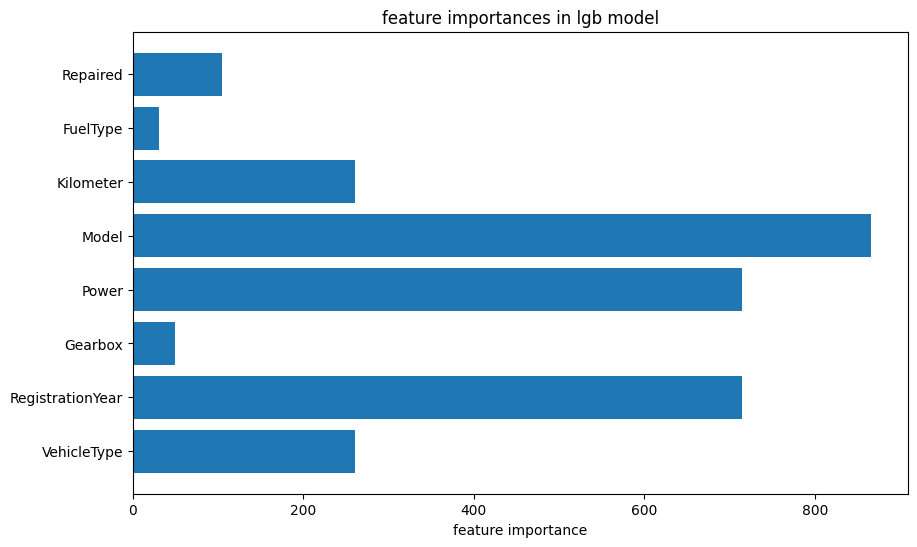

CPU times: total: 656 ms
Wall time: 448 ms


In [33]:
%%time
pred = lgb_model.predict(features_valid)
rmse = mean_squared_error(target_valid, pred) ** 0.5
print(f'rmse: {rmse}')

feature_importances = lgb_model.feature_importances_
feature_names = features.columns

for name, importance in zip(feature_names, feature_importances):
    print(f'{name}: {importance}')

plt.figure(figsize=(10, 6))
plt.barh(feature_names, feature_importances)
plt.xlabel('feature importance')
plt.title('feature importances in lgb model')
plt.show()

In [34]:
%%time
cat_model = catboost.CatBoostRegressor(silent=True)
cat_model.fit(features_train, target_train)


CPU times: total: 1min 6s
Wall time: 24.3 s


rmse: 1608.0437729992068

VehicleType: 4.627646641807664
RegistrationYear: 40.82241803956053
Gearbox: 0.8529699389838636
Power: 24.392630147706658
Model: 17.91534767448854
Kilometer: 8.594037296536483
FuelType: 0.1552649090333373
Repaired: 2.639685351882924


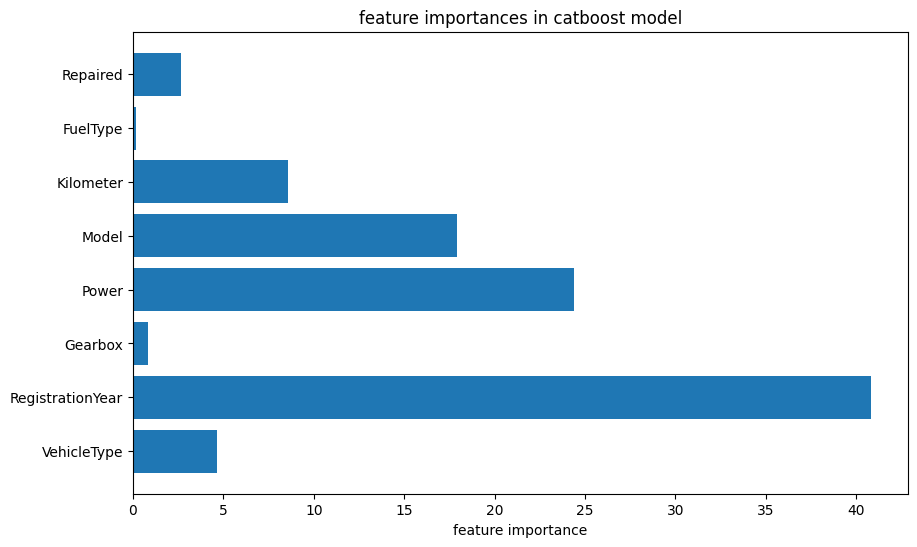

CPU times: total: 344 ms
Wall time: 322 ms


In [35]:
%%time
pred = cat_model.predict(features_valid)
rmse = mean_squared_error(target_valid, pred) ** 0.5
print(f'rmse: {rmse}\n')

feature_importances = cat_model.feature_importances_
feature_names = features.columns

for name, importance in zip(feature_names, feature_importances):
    print(f'{name}: {importance}')

plt.figure(figsize=(10, 6))
plt.barh(feature_names, feature_importances)
plt.xlabel('feature importance')
plt.title('feature importances in catboost model')
plt.show()

## Тестирование

In [37]:
X = np.concatenate([features_train, features_valid])
y = np.concatenate([target_train, target_valid])

In [38]:
model = catboost.CatBoostRegressor(silent=True)
model.fit(X, y) 

In [39]:
pred = model.predict(features_test)
rmse = mean_squared_error(target_test, pred) ** 0.5
print(f'rmse: {rmse}')

rmse: 1625.6138651702577


## Итоги  
Обработал изначальные данные, очистил от аномалий и пропусков  
Протестировал модели регрессии: линейную от sklearn, lgb и от catboost  
Самой точной оказалась модель CatBoostRegressor c rmse ~1608, однако время ее обучения как минимум у меня заняло 1.5 минуты, а модель LGBMRegressor заняла всего 5 секунл, но результат был несильно хуже, порядка rmse ~1682, когда время предсказаний у всех обученных моделей меньше секунды